## Vehicle price estimator based on the Romanian market: XGBRegressor

### Imports

In [ ]:
import pandas as pd
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import xgboost as xgb

from tqdm import tqdm
from xgboost import XGBRegressor
from numpy import arange
from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso

### Constants

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_TRAIN = "/content/drive/MyDrive/EDA/EDA_dataset/train.csv"
PATH_VALID = "/content/drive/MyDrive/EDA/EDA_dataset/validation.csv"

PATH_PLOTS = "/content/drive/MyDrive/EDA/Plots"
PATH_MODELS = "/content/drive/MyDrive/EDA/Models"
MODEL_SAVE_PATH_PREFIX = '/content/drive/MyDrive/EDA/Models/Model_'
os.makedirs(PATH_PLOTS, exist_ok=True)

### Read data

In [ ]:
data_train = pd.read_csv(PATH_TRAIN)
data_valid = pd.read_csv(PATH_VALID)

# Separate features (X) and target variable (y)
y_train = data_train['Pret']
X_train = data_train.drop('Pret', axis=1)

y_valid = data_valid['Pret']
X_valid = data_valid.drop('Pret', axis=1)

print(X_train.head())

                     Versiune  Vechime      Km  Putere  Capacitate cilindrica  \
0          D4 AWD Inscription      6.0  124000     190                   1969   
1      109 CDI Extralung Mixt      5.0   36000      90                   1461   
2  1.6 BlueHDi FAP STT Active      8.0  219000     120                   1560   
3      2.2 CRDi 2WD Signature      4.0   51500     202                   2151   
4                  1.8 TSI FR     11.0  228300     160                   1798   

           Marca     Model Combustibil     Transmisie Norma de poluare  \
0          Volvo     XC 60      Diesel  4x4 (automat)           Euro 6   
1  Mercedes-Benz     Citan      Diesel           Fata           Euro 6   
2        Peugeot       308      Diesel           Fata           Euro 6   
3        Hyundai  Santa Fe      Diesel           Fata           Euro 6   
4           Seat      Leon     Benzina           Fata           Euro 5   

  Cutie de viteze Tip Caroserie Optiuni culoare Tara de origine     

### Features

In [ ]:
numeric_features = ["Km", "Vechime", "Capacitate cilindrica", "Putere"]
categorical_features = ["Marca", "Model", "Versiune", "Combustibil", "Transmisie", "Norma de poluare", "Tip Caroserie", "Cutie de viteze", "Stare", "Tara de origine", "Optiuni culoare"]


### Preprocessor

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [ ]:
X_train[categorical_features] = X_train[categorical_features].apply(lambda x: x.astype('category'))

In [ ]:
X_train['Transmisie'].dtype

CategoricalDtype(categories=['4x4 (automat)', '4x4 (manual)', 'Fata', 'Spate'], ordered=False)

In [ ]:
X_valid[categorical_features] = X_valid[categorical_features].apply(lambda x: x.astype('category'))

### Model

In [ ]:
# Define the regressor
regressor = XGBRegressor(enable_categorical=True)

### Model Pipeline

In [ ]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

### Train

In [ ]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Km', 'Vechime',
                                                   'Capacitate cilindrica',
                                                   'Putere'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              ear...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
filename = MODEL_SAVE_PATH_PREFIX + '_xgb_0' + '.pickle'
pickle.dump(model, open(filename, 'wb'))

### Test on validation

In [ ]:
predictions = model.predict(X_valid)

mae = mean_absolute_error(y_valid, predictions)
print("The MAE score of the model on validation data is: " + str(mae))

mse = mean_squared_error(y_valid, predictions)
print("The MSE score of the model on validation data is: " + str(mse))

rmse = mean_squared_error(y_valid, predictions, squared=False)
print("The RMSE score of the model on validation data is: " + str(rmse))


with open(os.path.join(PATH_PLOTS, "Logs.txt"), "w") as file:
    file.write("The MAE score of the model on validation data is: " + str(mae) + '\n')
    file.write("The MSE score of the model on validation data is: " + str(mse) + '\n')
    file.write("The RMSE score of the model on validation data is: " + str(rmse) + '\n')

The MAE score of the model on validation data is: 3136.664641660307
The MSE score of the model on validation data is: 66363527.67192213
The RMSE score of the model on validation data is: 8146.381262371786


### Plots

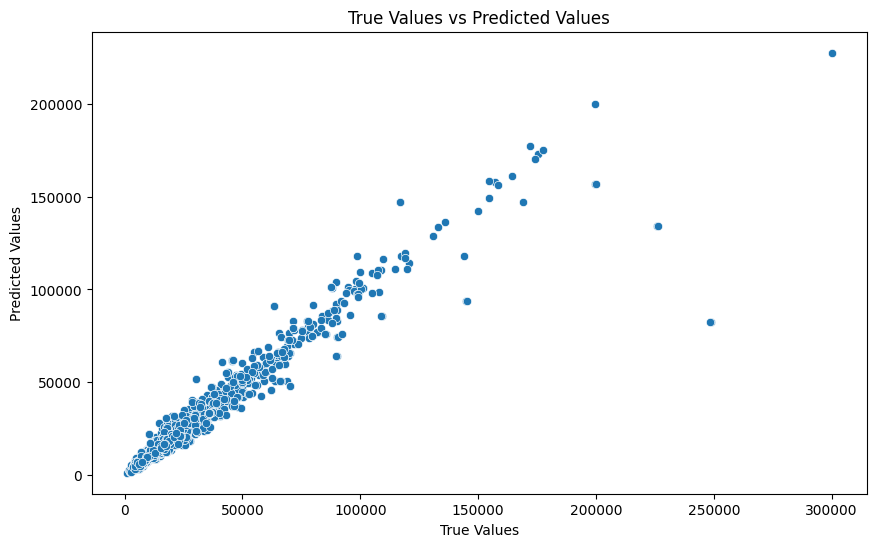

In [ ]:
# Create a scatter plot of true values vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=predictions)
plt.title('True Values vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.savefig(os.path.join(PATH_PLOTS, 'True_vs_predicted_plot_XGBRegressor_0.png'))
plt.show()

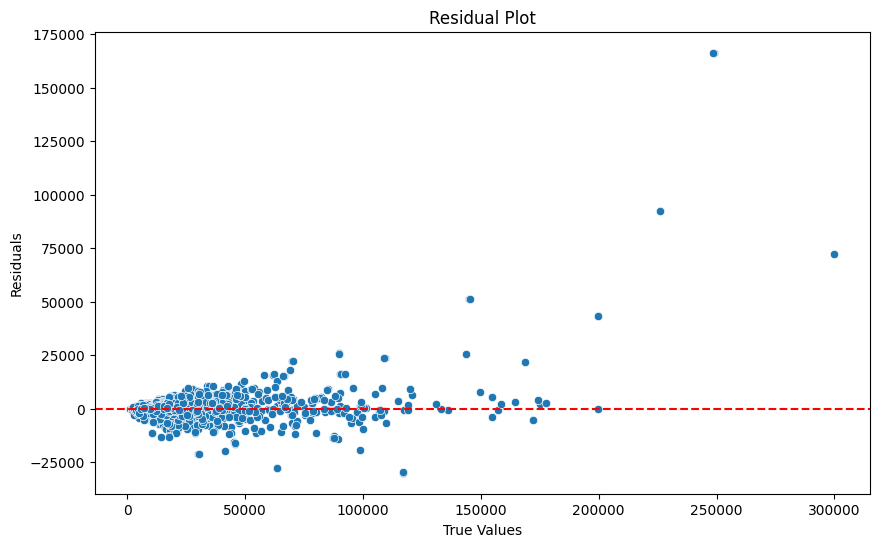

In [ ]:
# Create a residual plot to analyze errors
residuals = y_valid - predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.savefig(os.path.join(PATH_PLOTS, 'Residual_plot_XGBRegressor_0.png'))
plt.show()

### Hyperparameter tuning


In [ ]:
param_tuning = {
    'regressor__learning_rate': [0.001, 0.01, 0.1],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.5, 0.7],
    'regressor__colsample_bytree': [0.5, 0.7],
    'regressor__n_estimators': [100, 200, 500],
    'regressor__objective': ['reg:squarederror']
}

In [ ]:
xgb_model = XGBRegressor(enable_categorical=True)

In [ ]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

In [ ]:
gsearch_0 = GridSearchCV(estimator = model,
                      param_grid = param_tuning,
                      scoring = 'neg_mean_absolute_error',
                      cv = 5,
                      n_jobs = -1,
                      verbose = 1)

In [ ]:
gsearch_0.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Km',
                                                                          'Vechime',
                                                                          'Capacitate '
                                                                          'cilindrica',
                                                                          'Putere'])])),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsamp...
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'regressor__colsample_bytree': [0.5, 0.7],
                         'regressor__learning_rate': [0.001, 0.01, 0.1],
                         'regressor__max_depth': [3, 5, 7, 10],
                         'regressor__min_child_weight': [1, 3, 5],
                         'regressor__n_estimators': [100, 200, 500],
                         'regressor__objective': ['reg:squarederror'],
                         'regressor__subsample': [0.5, 0.7]},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
filename = MODEL_SAVE_PATH_PREFIX + '_gsearch_0' + '.pickle'
pickle.dump(gsearch_0, open(filename, 'wb'))

In [ ]:
best_params = gsearch_0.best_params_

In [ ]:
best_params

{'regressor__colsample_bytree': 0.5,
 'regressor__learning_rate': 0.1,
 'regressor__max_depth': 10,
 'regressor__min_child_weight': 1,
 'regressor__n_estimators': 500,
 'regressor__objective': 'reg:squarederror',
 'regressor__subsample': 0.7}

In [ ]:
best_estimator = gsearch_0.best_estimator_

### Test on Validation

In [ ]:
predictions = best_estimator.predict(X_valid)

mae = mean_absolute_error(y_valid, predictions)
print("The MAE score of the model on validation data is: " + str(mae))

mse = mean_squared_error(y_valid, predictions)
print("The MSE score of the model on validation data is: " + str(mse))

rmse = mean_squared_error(y_valid, predictions, squared=False)
print("The RMSE score of the model on validation data is: " + str(rmse))


with open(os.path.join(PATH_PLOTS, "Logs.txt"), "w") as file:
    file.write("The MAE score of the model on validation data is: " + str(mae) + '\n')
    file.write("The MSE score of the model on validation data is: " + str(mse) + '\n')
    file.write("The RMSE score of the model on validation data is: " + str(rmse) + '\n')

The MAE score of the model on validation data is: 2500.2754149784314
The MSE score of the model on validation data is: 74379936.23348266
The RMSE score of the model on validation data is: 8624.380339101624


### Plots

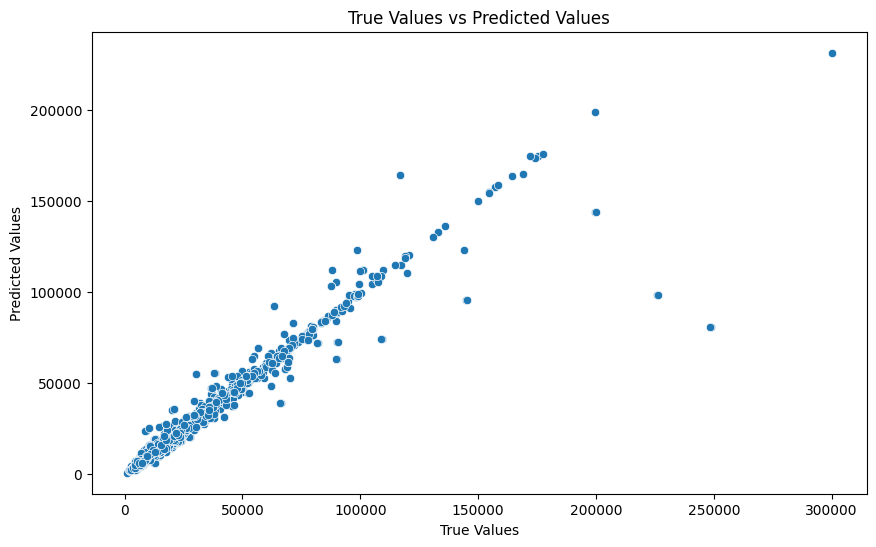

In [ ]:
# Create a scatter plot of true values vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=predictions)
plt.title('True Values vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.savefig(os.path.join(PATH_PLOTS, 'True_vs_predicted_plot_XGBRegressor_1.png'))
plt.show()

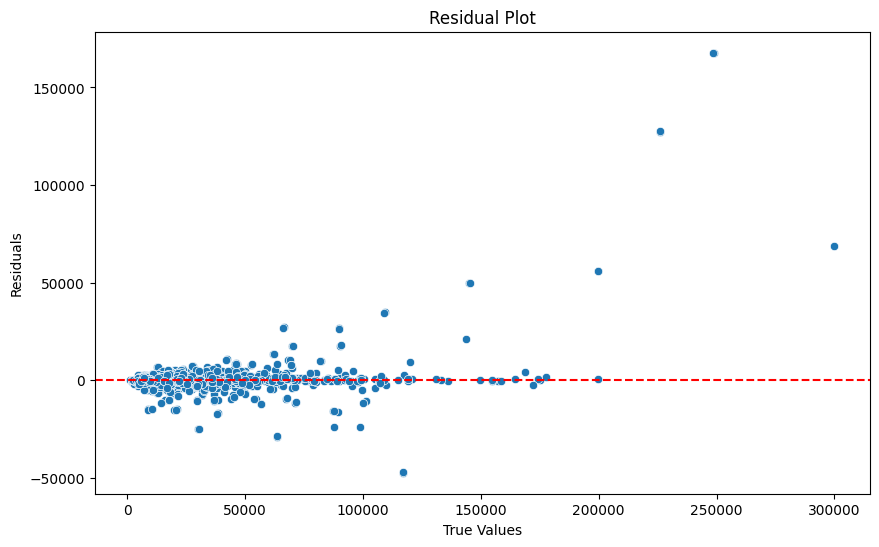

In [ ]:
# Create a residual plot to analyze errors
residuals = y_valid - predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.savefig(os.path.join(PATH_PLOTS, 'Residual_plot_XGBRegressor_1.png'))
plt.show()

### Second experiment with hyperparameter tuning

In [ ]:
param_tuning = {
    'regressor__learning_rate': [0.001, 0.01, 0.1],
    'regressor__max_depth': [10, 15],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.6, 0.7, 0.8],
    'regressor__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'regressor__n_estimators': [500],
    'regressor__objective': ['reg:squarederror']
}

In [ ]:
xgb_model = XGBRegressor(enable_categorical=True)

In [ ]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

In [ ]:
gsearch_1 = GridSearchCV(estimator = model,
                      param_grid = param_tuning,
                      scoring = 'neg_mean_absolute_error',
                      cv = 5,
                      n_jobs = -1,
                      verbose = 1)

In [ ]:
gsearch_1.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Km',
                                                                          'Vechime',
                                                                          'Capacitate '
                                                                          'cilindrica',
                                                                          'Putere'])])),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsamp...
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'regressor__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
                         'regressor__learning_rate': [0.001, 0.01, 0.1],
                         'regressor__max_depth': [10, 15],
                         'regressor__min_child_weight': [1, 3, 5],
                         'regressor__n_estimators': [500],
                         'regressor__objective': ['reg:squarederror'],
                         'regressor__subsample': [0.6, 0.7, 0.8]},
             scoring='neg_mean_absolute_error', verbose=1)

In [27]:
filename = MODEL_SAVE_PATH_PREFIX + '_gsearch_1_saved' + '.pickle'
pickle.dump(gsearch_1, open(filename, 'wb'))

In [ ]:
best_params = gsearch_1.best_params_

In [ ]:
best_params

{'regressor__colsample_bytree': 0.8,
 'regressor__learning_rate': 0.1,
 'regressor__max_depth': 15,
 'regressor__min_child_weight': 1,
 'regressor__n_estimators': 500,
 'regressor__objective': 'reg:squarederror',
 'regressor__subsample': 0.8}

In [ ]:
best_estimator = gsearch_1.best_estimator_

In [ ]:
predictions = best_estimator.predict(X_valid)

mae = mean_absolute_error(y_valid, predictions)
print("The MAE score of the model on validation data is: " + str(mae))

mse = mean_squared_error(y_valid, predictions)
print("The MSE score of the model on validation data is: " + str(mse))

rmse = mean_squared_error(y_valid, predictions, squared=False)
print("The RMSE score of the model on validation data is: " + str(rmse))


with open(os.path.join(PATH_PLOTS, "Logs.txt"), "w") as file:
    file.write("The MAE score of the model on validation data is: " + str(mae) + '\n')
    file.write("The MSE score of the model on validation data is: " + str(mse) + '\n')
    file.write("The RMSE score of the model on validation data is: " + str(rmse) + '\n')

The MAE score of the model on validation data is: 1691.2180780743395
The MSE score of the model on validation data is: 63477046.42823649
The RMSE score of the model on validation data is: 7967.248359894179


## Plots

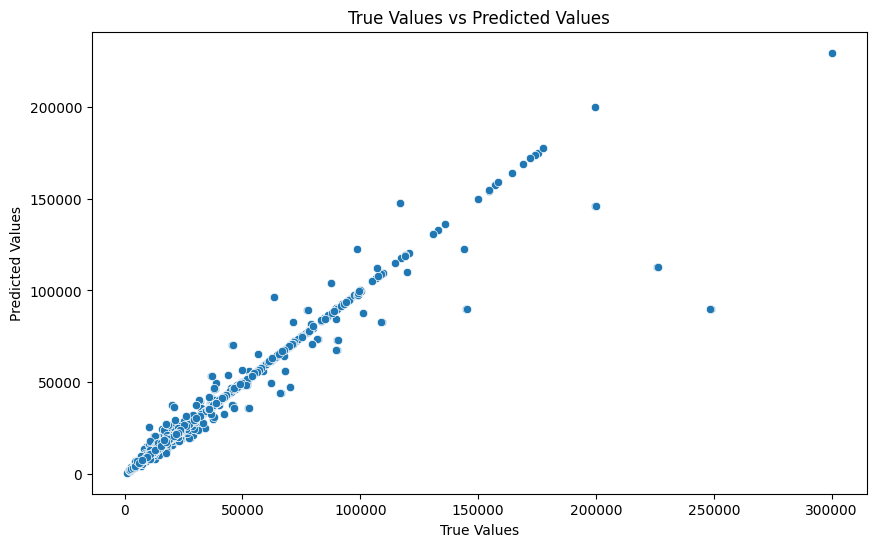

In [28]:
# Create a scatter plot of true values vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=predictions)
plt.title('True Values vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.savefig(os.path.join(PATH_PLOTS, 'True_vs_predicted_plot_XGBRegressor_2.png'))
plt.show()

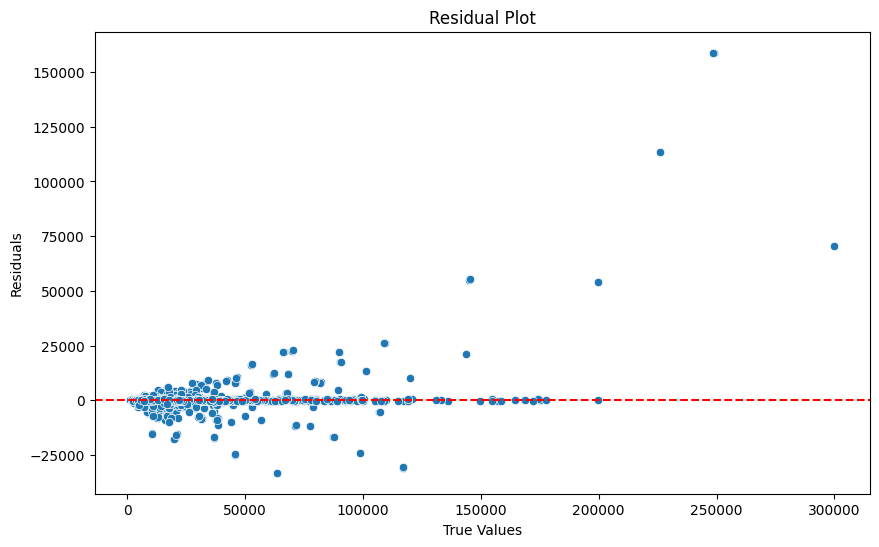

In [29]:
# Create a residual plot to analyze errors
residuals = y_valid - predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.savefig(os.path.join(PATH_PLOTS, 'Residual_plot__XGBRegressor_2.png'))
plt.show()